<a href="https://colab.research.google.com/github/markNZed/GPT-NeoX-Colab/blob/main/notebooks/codecompletion_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Modify torch and transformers which requires manual notebook restart
# Could not redirect to /dev/null in the standard Colab notebook (maybe no output for a particular time?)
# Currently deepspeed from GTP-NeoX is not compatible with logging in torch >= 2.4
%pip install --use-feature=fast-deps -q torch==2.3 &
%pip install --use-feature=fast-deps -q torchaudio==2.3.0 &
%pip install --use-feature=fast-deps -q torchvision==0.18.0 &
%pip install --use-feature=fast-deps -q transformers==4.38.0 &
%pip install --use-feature=fast-deps -q sentence-transformers==2.2.2 &

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.0 MB/s eta 0:00:00
   ━━

In [2]:
!apt install -y sysbench
# The Colab vCPU should give around 200 events per second. The high RAM instance type is around 350 (at twice the price)
# Given the price of T4 GPU and the percentage of time we spendin in setup is it worth using a high RAM instance
# The high RAM instance has 8 threads instead of 2 and can reach around 1600 events per second with all 8 threads
!sysbench cpu --cpu-max-prime=20000 run

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
sysbench is already the newest version (1.0.20+ds-2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
sysbench 1.0.20 (using system LuaJIT 2.1.0-beta3)

Running the test with following options:
Number of threads: 1
Initializing random number generator from current time


Prime numbers limit: 20000

Initializing worker threads...

Threads started!

CPU speed:
    events per second:   394.31

General statistics:
    total time:                          10.0006s
    total number of events:              3944

Latency (ms):
         min:                                    2.34
         avg:                                    2.53
         max:                                    4.00
         95th percentile:                        3.30
         sum:                                 9997.83

Threads fairness:
    events (avg/stddev):           3944.0000/0.00
    execution time (avg

In [3]:
# We could modify these paths to "stub" behavior for test/dev
workspaceDir = "/content"
GPTNeoXDirName = "gpt-neox"
GPTNeoXDir = f"{workspaceDir}/{GPTNeoXDirName}"
GPTNeoXColabDirName = "GPT-NeoX-Colab"
GPTNeoXColabDir = f"{workspaceDir}/{GPTNeoXColabDirName}"

# Clone CodeXGLUE Repo

In [4]:
!git clone https://github.com/microsoft/CodeXGLUE.git &

Cloning into 'CodeXGLUE'...
remote: Enumerating objects: 3373, done.
remote: Counting objects: 100% (3372/3372), done.
remote: Compressing objects: 100% (1534/1534), done.
remote: Total 3373 (delta 1746), reused 3329 (delta 1733), pack-reused 1 (from 1)
Receiving objects: 100% (3373/3373), 213.15 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (1746/1746), done.
Updating files: 100% (400/400), done.


In [5]:
#@title Clone GPT-NeoX-Colab
%%time
%cd {workspaceDir}
# Don't use --depth 1 because that does not play nice with git-annex
!git clone https://github.com/markNZed/GPT-NeoX-Colab.git
%cd {GPTNeoXColabDir}
#%pip install --use-feature=fast-deps -q -r requirements_colab.txt
!cat requirements_colab.txt | xargs -n 1 -P 8 pip install --use-feature=fast-deps -q
%pip install --use-feature=fast-deps -q .
from dotenv import load_dotenv
import os
load_dotenv(f"{GPTNeoXColabDir}/.env")
import GPTNeoXColab
GPTNeoXColab.utils.colab.fetch_data("data/codecompletion/processed_data")

/content
Cloning into 'GPT-NeoX-Colab'...
remote: Enumerating objects: 1335, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 1335 (delta 172), reused 136 (delta 65), pack-reused 1052 (from 1)
Receiving objects: 100% (1335/1335), 13.90 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (749/749), done.
/content/GPT-NeoX-Colab
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 80.8 MB/

In [6]:
%cd {workspaceDir}
#!git clone https://github.com/EleutherAI/gpt-neox.git
!git clone -b pipe_parallel_size_1 --depth 1 https://github.com/markNZed/gpt-neox.git

/content
Cloning into 'gpt-neox'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 296 (delta 74), reused 138 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (296/296), 2.50 MiB | 4.71 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [7]:
!mkdir -p /content/gpt-neox/processed_data
!cp {GPTNeoXColabDir}/data/codecompletion/processed_data/* /content/gpt-neox/processed_data
processed_data_path = "/content/gpt-neox/processed_data"

# Cloning GPT-NeoX Repo

# Downloading and Preprocessing Dataset

In [8]:
import os

# Check if the file exists
if not os.path.exists(processed_data_path):
    # Change directory
    %cd /content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150
    # Run the shell script to download and extract
    !bash /content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150/download_and_extract.sh
    # Run the preprocessing Python script
    !python preprocess.py --base_dir=py150_files --output_dir=token_completion
else:
    print("File already exists, skipping download and preprocessing.")


File already exists, skipping download and preprocessing.


# Install Dependencies

In [9]:
%%time
%cd /content/gpt-neox
#%pip install --use-feature=fast-deps -q -r ./requirements/requirements.txt
!cat ./requirements/requirements.txt | xargs -n 1 -P 8 pip install --use-feature=fast-deps -q

/content/gpt-neox
  Cloning https://github.com/EleutherAI/DeeperSpeed.git (to revision 02e2ebf7dee6aaab3d89094ed470a4609763c742) to /tmp/pip-install-gn9o1wsj/deepspeed_d5bc2ffa37194ad6a0d9bd2e6f2263dd
  Running command git clone --filter=blob:none --quiet https://github.com/EleutherAI/DeeperSpeed.git /tmp/pip-install-gn9o1wsj/deepspeed_d5bc2ffa37194ad6a0d9bd2e6f2263dd
  Running command git rev-parse -q --verify 'sha^02e2ebf7dee6aaab3d89094ed470a4609763c742'
  Running command git fetch -q https://github.com/EleutherAI/DeeperSpeed.git 02e2ebf7dee6aaab3d89094ed470a4609763c742
  Running command git checkout -q 02e2ebf7dee6aaab3d89094ed470a4609763c742
  Resolved https://github.com/EleutherAI/DeeperSpeed.git to commit 02e2ebf7dee6aaab3d89094ed470a4609763c742
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/EleutherAI/lm_dataformat.git (to revision 4eec05349977071bf67fc072290b95e31c8dd836) to /tmp/pip-install-gn

# Preparing Custom Dataset


In [10]:
%cd /content/gpt-neox
!mkdir -p data

/content/gpt-neox


In [11]:
import json
import os

# Generate a list of dictionaries
if not os.path.exists(processed_data_path):
  lines = []
  with open("/content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150/token_completion/train.txt", encoding="utf8") as f:
      for line in f.read().splitlines():
          if line:
              lines.append({"text": line})

  # Convert to a list of JSON strings
  json_lines = [json.dumps(l) for l in lines]

  # Join lines and save to .jsonl file
  json_data = '\n'.join(json_lines)
  with open('/content/gpt-neox/data/py95K_train.jsonl', 'w') as f:
      f.write(json_data)

# Using Byte-Pair Encoding Tokenizer

In [12]:
%cd data
!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json &
!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt

/content/gpt-neox/data
--2024-11-14 08:09:00--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.74.248, 52.216.215.24, 54.231.128.136, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.74.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [application/json]
Saving to: ‘gpt2-vocab.json’

gpt2-vocab.json     100%[===================>]   1018K  1.05MB/s    in 0.9s    

2024-11-14 08:09:02 (1.05 MB/s) - ‘gpt2-vocab.json’ saved [1042301/1042301]

--2024-11-14 08:09:02--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.74.248, 52.216.215.24, 54.231.128.136, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.74.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [text/plain]
Saving to: ‘gpt2-merges.txt’

gpt2-merges.txt     100%[============

In [13]:
%%time
import os

# Check if the file exists
if not os.path.exists(processed_data_path):
  %cd /content/gpt-neox
  !mkdir -p processed_data
  !python tools/datasets/preprocess_data.py \
    --input ./data/py95K_train.jsonl \
    --vocab ./data/gpt2-vocab.json \
    --merge-file ./data/gpt2-merges.txt \
    --output-prefix ./processed_data/py150 \
    --tokenizer-type GPT2BPETokenizer \
    --dataset-impl mmap \
    --append-eod
else:
    print("File already exists, skipping download and preprocessing.")


File already exists, skipping download and preprocessing.
CPU times: user 74 µs, sys: 13 µs, total: 87 µs
Wall time: 76.1 µs


# Tokens count in Dataset

In [14]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer (BPE-based)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Path to your text file
file_path = "/content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150/token_completion/train.txt"

# Initialize a token counter
total_token_count = 0

# Open the file and read line by line to count tokens
#with open(file_path, "r", encoding="utf-8") as file:
#    for line in file:
#        tokens = tokenizer.encode(line)
#        total_token_count += len(tokens)
        #print(total_token_count)

print(f"Total token count: {total_token_count}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Total token count: 0


# Training

In [15]:
%load_ext tensorboard

In [16]:
%%time
%cd /content/gpt-neox
!python ./deepy.py train.py --conf_dir /content/GPT-NeoX-Colab/configs codecompletion codecompletion_train

/content/gpt-neox
[2024-11-14 08:09:11,327] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/content/gpt-neox/megatron/neox_arguments/arguments.py:1101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/content/gpt-neox/megatron/neox_arguments/arguments.py:1110: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
NeoXArgs.from_ymls() ['/content/GPT-NeoX-Colab/configs/codecompletion.yml', '/content/GPT-NeoX-Colab/configs/codecompletion_train.yml']
INFO:root:NeoXArgs.calculate_derived() Total number of GPUs determined to be: 1
-------------------- arguments --------------------
  attention_config ................ ['global', 'global', 'global', 'global', 'global', 'global']updated
  batch_size ...................... 4...........................updated
  checkpoint_factor ............... 50..........................updated
  config_files .................... {'codecompletion.yml': '{\n 

In [17]:
!pip show datasets
!pip install datasets==1.18.0
!pip install hf-transfer
!pip install lm-eval --upgrade

Name: datasets
Version: 3.1.0
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, dill, filelock, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: evaluate, lm_eval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.3/311.3 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 3.1.0
    Uninstalling datasets-3.1.0:
      Successfully uninstalled datasets-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
evaluate 0.4.3 requires datasets>=2.0.0, but you have datasets 1.18.0 which is incompatible.
lm-eval 0.4.1 requires datasets>=2.14.0

# Inference

/content/gpt-neox
Available scalar keys: ['timers/forward', 'timers/backward', 'timers/backward-backward', 'timers/backward-allreduce', 'timers/optimizer', 'timers/batch generator', 'train/learning_rate', 'train/lm_loss', 'train/loss_scale', 'runtime/samples_per_sec', 'runtime/iteration_time', 'runtime/flops_per_sec_per_gpu', 'validation/lm_loss', 'validation/lm_loss_ppl', 'test/lm_loss', 'test/lm_loss_ppl']


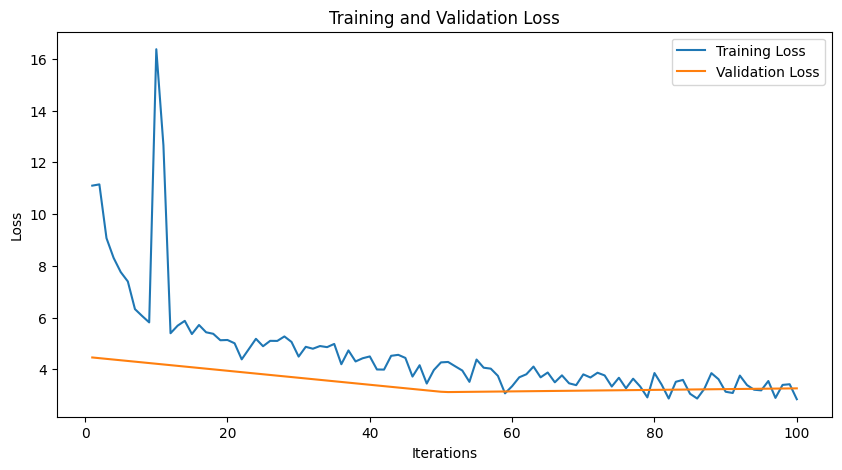

In [18]:
%cd /content/gpt-neox

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os
import numpy as np
# Path to the latest log file
log_dir = "tensorboard"
log_files = [os.path.join(log_dir, d) for d in os.listdir(log_dir)]
latest_log_dir = max(log_files, key=os.path.getmtime)

# Initialize EventAccumulator to load scalar data
ea = event_accumulator.EventAccumulator(latest_log_dir)
ea.Reload()  # Load all logs

# List all scalar keys available in the logs
scalar_keys = ea.Tags()['scalars']
print("Available scalar keys:", scalar_keys)

# Extract training and validation losses
train_loss = ea.Scalars('train/lm_loss')  # Adjust for actual name if necessary
val_loss = ea.Scalars('validation/lm_loss')  # Adjust for actual name if necessary

# Convert to lists for plotting
train_loss_values = [x.value for x in train_loss]
val_loss_values = [x.value for x in val_loss]

# Find the lengths of both arrays
len_train = len(train_loss_values)
len_val = len(val_loss_values)

iterations = None
# Interpolate the shorter array
if len_train != len_val:
    if len_train > len_val:
        # Interpolate validation loss to match the training loss length
        iterations = np.linspace(1, len_train, len_train)
        val_iterations = np.linspace(1, len_train, len_val)
        val_loss_values = np.interp(iterations, val_iterations, val_loss_values)
    else:
        # Interpolate training loss to match the validation loss length
        iterations = np.linspace(1, len_val, len_val)
        train_iterations = np.linspace(1, len_val, len_train)
        train_loss_values = np.interp(iterations, train_iterations, train_loss_values)
else:
    iterations = range(1, len_train + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss_values, label='Training Loss')
plt.plot(iterations, val_loss_values, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# HuggingFace Inference

# Convert Our Model to HuggingFace Format

In [19]:
import os

# Define the path to the checkpoints directory
checkpoints_dir = "/content/gpt-neox/checkpoints"

# Read the 'latest' file to get the latest checkpoint name
with open(os.path.join(checkpoints_dir, "latest"), "r") as f:
    latest_checkpoint_name = f.read().strip()

# Construct the full path to the latest checkpoint directory
latest_checkpoint_path = os.path.join(checkpoints_dir, latest_checkpoint_name)
print("Path to the latest checkpoint:", latest_checkpoint_path)

Path to the latest checkpoint: /content/gpt-neox/checkpoints/global_step100


In [20]:
!python ./tools/ckpts/convert_neox_to_hf.py --input_dir {latest_checkpoint_path} --config_file /content/GPT-NeoX-Colab/configs/codecompletion.yml --output_dir hf_model/save/location --precision auto --architecture neox

[2024-11-14 08:11:25,455] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Detected 'pipe-parallel-size' of 0, assuming model is saved as Sequential...
> building GPT2BPETokenizer tokenizer ...
 > padded vocab (size: 50257) with 47 dummy tokens (new size: 50304)
Auto-detecting precision to save model into...
Saving weights in fp16 precision...
Detected MLP naming convention: new
100% 6/6 [00:00<00:00, 181.49it/s]


# Code Completion

In [21]:
from transformers import GPTNeoXForCausalLM
import torch

# Move to model directory
%cd /content/gpt-neox

# Assuming CharLevelTokenizer is properly imported and instantiated
from megatron.tokenizer.tokenizer import _GPT2BPETokenizer
tokenizer = _GPT2BPETokenizer(vocab_file="data/gpt2-vocab.json", merge_file="data/gpt2-merges.txt")

# Load your model
model_path = "/content/gpt-neox/hf_model/save/location"
model = GPTNeoXForCausalLM.from_pretrained(model_path)

# Define a simple char-level tokenizer if not provided
def token_level_tokenize(text):
    return tokenizer.tokenize(text)

def token_level_detokenize(tokens):
    return tokenizer.detokenize(tokens)

# Set the model to evaluation mode
model.eval()

# Prompt the user for input
input_text = """<s> import sys , os <EOL> import imp <EOL> from optparse import make_option <EOL> from django . conf import settings <EOL> from django . utils . importlib import import_module <EOL> from django . core . management import call_command <EOL> from django . core . management import BaseCommand <EOL> from django . db import connections <EOL> def import_app ( app_label , verbosity ) : <EOL> try : <EOL> app_path = __import__ ( app_label , { } , { } , [ app_label . split ( '<STR_LIT:.>' ) [ - <NUM_LIT:1> ] ] ) . __path__ <EOL>"""

# Tokenize and prepare input
input_ids = torch.tensor([token_level_tokenize(input_text)], dtype=torch.long)
attention_mask = torch.ones_like(input_ids)  # Create an attention mask for non-padded input

# Generate text with specified pad_token_id and attention_mask
with torch.no_grad():
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=200,          # Adjust this for desired output length
        temperature=0.7,        # Controls creativity
        top_k=50,               # Controls diversity
        top_p=0.9,              # Nucleus sampling
        num_return_sequences=1, # Number of sequences to return
        pad_token_id=model.config.eos_token_id,  # Set pad_token_id explicitly
        do_sample=True           # Enable sampling mode to use temperature and top_p
    )

# Decode the generated text
generated_text = token_level_detokenize(output[0].tolist())

# Function to replace special tokens with original representations
def replace_special_tokens(text):
    replacements = {
        "<EOL>": "\n",  # Replace with actual newline
        "<s>": "",
        "</s>": "",     # Remove end token
        "<STR_LIT>": "STR_LITERAL",  # Example replacement, adjust as necessary
        "<NUM_LIT>": "NUM_LITERAL",   # Example replacement, adjust as necessary
    }

    for token, replacement in replacements.items():
        text = text.replace(token, replacement)

    return text.strip()  # Strip leading/trailing whitespace

# Replace special tokens in the generated text
final_text = replace_special_tokens(generated_text)

# Print the final output
print("Generated text:", final_text)


/content/gpt-neox
[2024-11-14 08:11:31,088] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Generated text: import sys, os 
 import imp 
 from optparse import make_option 
 from django. conf import settings 
 from django. utils. importlib import import_module 
 from django. core. management import call_command 
 from django. core. management import BaseCommand 
 from django. db import connections 
 def import_app ( app_label, verbosity ) : 
 try : 
 app_path = __import__ ( app_label, { }, { }, [ app_label. split ( '<STR_LIT:.>' ) [ - <NUM_LIT:1> ] ] ). __path__ 
', ) 
EOL>', 
STR_LITERAL if self


In [24]:
import os

# Check if the file exists
if not os.path.exists("/content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150/token_completion"):
    # Change directory
    %cd /content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150
    # Run the shell script to download and extract
    !bash /content/CodeXGLUE/Code-Code/CodeCompletion-token/dataset/py150/download_and_extract.sh
    # Run the preprocessing Python script
    !python preprocess.py --base_dir=py150_files --output_dir=token_completion
else:
    print("File already exists, skipping download and preprocessing.")

Streaming output truncated to the last 5000 lines.
data/mathcamp/pypicloud/pypicloud/views/simple.py
data/mathcamp/pypicloud/pypicloud/views/api.py
data/mathcamp/pypicloud/pypicloud/models.py
data/mathcamp/pypicloud/pypicloud/cache/
data/mathcamp/pypicloud/pypicloud/cache/__init__.py
data/mathcamp/pypicloud/pypicloud/cache/redis_cache.py
data/mathcamp/pypicloud/pypicloud/cache/dynamo.py
data/mathcamp/pypicloud/pypicloud/cache/sql.py
data/mathcamp/pypicloud/pypicloud/access/
data/mathcamp/pypicloud/pypicloud/access/base.py
data/mathcamp/pypicloud/pypicloud/access/remote.py
data/mathcamp/pypicloud/pypicloud/access/config.py
data/mathcamp/pypicloud/doc/
data/mathcamp/pypicloud/doc/extensions/
data/mathcamp/pypicloud/doc/extensions/github.py
data/apendleton/
data/apendleton/djmicro/
data/apendleton/djmicro/example/
data/apendleton/djmicro/example/web.py
data/sdiehl/
data/sdiehl/numpile/
data/sdiehl/numpile/numpile.py
data/sdiehl/numpush/
data/sdiehl/numpush/examples/
data/sdiehl/numpush/ex

In [25]:
!cp /content/gpt-neox/data/gpt2-vocab.json /content/gpt-neox/hf_model/save/location/vocab.json
!cp /content/gpt-neox/data/gpt2-merges.txt /content/gpt-neox/hf_model/save/location/merges.txt
%cd /content/CodeXGLUE/Code-Code/CodeCompletion-token/code
!python -u run_lm.py \
        --data_dir=../dataset/py150/token_completion \
        --lit_file=../dataset/py150/literals.json \
        --langs=$LANG \
        --output_dir=../dataset/py150 \
        --pretrain_dir=/content/gpt-neox/hf_model/save/location \
        --log_file=../completion_python_eval.log \
        --model_type=gpt2 \
        --block_size=2048 \
        --do_eval \
        --per_gpu_eval_batch_size=4 \
        --logging_steps=100 \
        --seed=42

/content/CodeXGLUE/Code-Code/CodeCompletion-token/code
11/14/2024 08:39:14 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False, world size: 1
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizerFast'. 
The class this function is called from is 'GPT2Tokenizer'.
You are using a model of type gpt_neox to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at /content/gpt-neox/hf_model/save/location and are newly initialized: ['h.0.attn.c_attn.bias', 'h.0.attn.c_attn.weight', 'h.0.attn.c_proj.bias', 'h.0.attn.c_proj.weight', 'h.0.ln_1.bias', 'h.0.ln_1.weight', 'h.0.ln_2.bias', 'h.0.ln_2.weight', 'h.0.mlp.c_fc.bias',